# Capstone Project: Cybersecurity Attacks Analysis

**Overview**: For my capstone project in UC Berkeley's ML/AI bootcamp, I will be analyzing a dataset of cyberattacks and identifying factors which affect how severe an attack is. The goal for the project is to train a classification model that will be able to accurately predict how severe an attack will be given some input.



## Dataset

This dataset comes from Kaggle [link](https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks). The data is a synthetic dataset created by Incribo which provides an accurate realistic representation of travel history. Incribo themselves seem to be a startup that creates synthetic datasets to train AI models.

## Business Objective

Our objective in this project is to create a classification model that can accurately predict how severe a cybersecurity attack is. These predictions will be based on the features in the cyberattack dataset. In addition, we would like to identify features that have a strong impact on the model so that we can find what causes the severity of these attacks.

## Reading in the Data

We have already imported the dataset into the /data folder. So we will extract it with pandas.

In [8]:
import pandas as pd

In [9]:
cyber_attacks = pd.read_csv( "data/cybersecurity_attacks.csv" )

In [10]:
cyber_attacks.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


## Exploring the Data

Now that we have loaded in the data, we should look through it for missing values and features that we may need to change or manipulate.

In [12]:
cyber_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

As we can see, the dataset has a total of 40000 records and 25 features.

For the target variable, we would like to use "Severity Level" since that is the most applicable to our project.

In addition, most features aren't missing any values. Only "Alerts/Warnings", "Malware Indicators", "Proxy Information", "Firewall Logs", and "IDS/IPS Alerts" are missing half. Thus, lets look into these to see if they're important

In [14]:
cyber_attacks["Malware Indicators"].value_counts()

Malware Indicators
IoC Detected    20000
Name: count, dtype: int64

In [15]:
cyber_attacks["Alerts/Warnings"].value_counts()

Alerts/Warnings
Alert Triggered    19933
Name: count, dtype: int64

In [16]:
cyber_attacks["Proxy Information"].value_counts()

Proxy Information
39.123.165.122     2
150.9.97.135       1
198.80.71.196      1
108.143.243.168    1
211.195.173.251    1
                  ..
205.112.169.158    1
78.192.52.63       1
157.191.153.187    1
205.183.87.116     1
112.169.115.139    1
Name: count, Length: 20148, dtype: int64

In [17]:
cyber_attacks["Firewall Logs"].value_counts()

Firewall Logs
Log Data    20039
Name: count, dtype: int64

In [18]:
cyber_attacks["IDS/IPS Alerts"].value_counts()

IDS/IPS Alerts
Alert Data    19950
Name: count, dtype: int64

As we can see, most of these features are actually binary features. Thus, when we prepare the data, we can transform these into binary features. As for "Proxy Information", it seems to be the proxy's IP address, which is very unique. As a result, it might be best to ignore this field for now.

Lets look at the rest of the data:

#### Timestamp

In [22]:
print( "Earliest Attack:", min( cyber_attacks["Timestamp"] ) )
print( "Latest Attack:", max( cyber_attacks["Timestamp"] ) )

Earliest Attack: 2020-01-01 00:43:27
Latest Attack: 2023-10-11 19:34:23


It seems the time of attacks are all between 2020 to 2023. It would be nice to encode all of this data. Looking around on Google, this article (https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features) and (https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning) provides some insight on how to encode datetime. We can divide the timestamp to year, month, day, and time, and get their sin and cosine (except for year since it isn't cyclical). These two variables save the cyclical behavior of the time, so distance between them are still being represented.

Thus, when we deal with timestamp, we should first separate it and transform the parts to representable features

#### IP Addresses

In [25]:
cyber_attacks["Source IP Address"].value_counts()

Source IP Address
103.216.15.12      1
74.225.47.66       1
147.178.224.232    1
119.183.250.156    1
80.60.140.131      1
                  ..
8.73.26.79         1
15.232.18.232      1
71.157.156.214     1
200.15.203.154     1
14.102.21.108      1
Name: count, Length: 40000, dtype: int64

In [26]:
cyber_attacks["Destination IP Address"].value_counts()

Destination IP Address
84.9.164.252       1
131.248.231.186    1
48.157.39.218      1
112.135.140.167    1
125.252.191.10     1
                  ..
46.159.49.250      1
186.100.212.78     1
168.135.234.183    1
22.16.168.57       1
109.198.45.7       1
Name: count, Length: 40000, dtype: int64

Similar to "Proxy Information", each IP address is unique in both sender and receiver. Thus, it's probably not worthwhile to transform this data into something usable. So, when preparing the data, we should remove these 2 features

#### Ports

In [29]:
cyber_attacks["Source Port"].value_counts()

Source Port
41341    6
31656    5
8653     5
24528    5
60026    5
        ..
49864    1
17928    1
20877    1
45259    1
50137    1
Name: count, Length: 29761, dtype: int64

In [30]:
cyber_attacks["Destination Port"].value_counts()

Destination Port
34117    6
7508     6
30804    5
37248    5
57508    5
        ..
7380     1
55244    1
60637    1
3884     1
25152    1
Name: count, Length: 29895, dtype: int64

Similar to IP Addresses, the number of unique ports is too large. It isn't a numerical feature, so if we converted it to a categorical feature, it would add over ten thousand features. Thus, we should also discard these as well.

#### Protocol, Packet, and Traffic

In [33]:
cyber_attacks["Protocol"].value_counts()

Protocol
ICMP    13429
UDP     13299
TCP     13272
Name: count, dtype: int64

In [34]:
# Packet Length is numerical, so lets see the histogram of it
import seaborn as sns

<Axes: xlabel='Packet Length', ylabel='Count'>

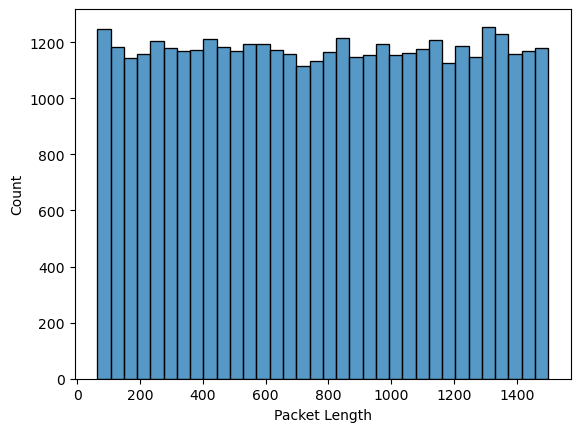

In [35]:
sns.histplot( cyber_attacks["Packet Length"] )

In [36]:
cyber_attacks["Packet Type"].value_counts()

Packet Type
Control    20237
Data       19763
Name: count, dtype: int64

In [37]:
cyber_attacks["Traffic Type"].value_counts()

Traffic Type
DNS     13376
HTTP    13360
FTP     13264
Name: count, dtype: int64

As we can see, these 4 features are actually very well evenly distributed. Thus, there's not much to do for these features except for scaling the packet length

#### Payload Data

In [40]:
cyber_attacks["Payload Data"].head()

0    Qui natus odio asperiores nam. Optio nobis ius...
1    Aperiam quos modi officiis veritatis rem. Omni...
2    Perferendis sapiente vitae soluta. Hic delectu...
3    Totam maxime beatae expedita explicabo porro l...
4    Odit nesciunt dolorem nisi iste iusto. Animi v...
Name: Payload Data, dtype: object

From what we can see, the payload data is all in Latin text. In addition, they are all pretty unique. We could change this to length of payload data, which could intersect with "Packet Length". But it should be okay since they are separate features

#### Attack Details

<Axes: xlabel='Anomaly Scores', ylabel='Count'>

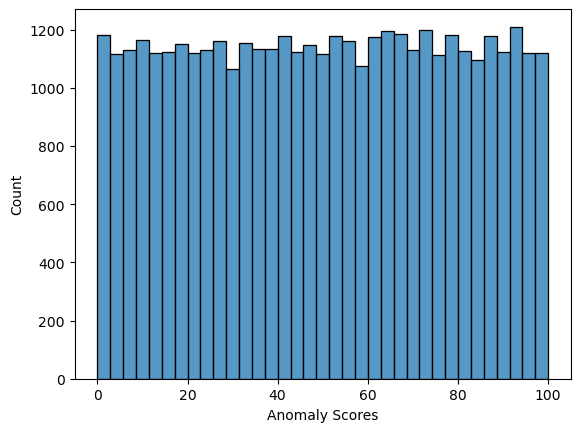

In [43]:
sns.histplot( cyber_attacks["Anomaly Scores"] )

In [44]:
cyber_attacks["Attack Type"].value_counts()

Attack Type
DDoS         13428
Malware      13307
Intrusion    13265
Name: count, dtype: int64

In [45]:
cyber_attacks["Attack Signature"].value_counts()

Attack Signature
Known Pattern A    20076
Known Pattern B    19924
Name: count, dtype: int64

In [46]:
cyber_attacks["Action Taken"].value_counts()

Action Taken
Blocked    13529
Ignored    13276
Logged     13195
Name: count, dtype: int64

In [47]:
cyber_attacks["Severity Level"].value_counts()

Severity Level
Medium    13435
High      13382
Low       13183
Name: count, dtype: int64

Similarly, all of these features are evenly distributed as well. Nothing much to do except scale the anomaly score.

#### User/Device Information

In [50]:
cyber_attacks["User Information"].value_counts()

User Information
Ishaan Chaudhari    6
Heer Lad            6
Ishita Chaudry      5
Yasmin Ghose        5
Tara Madan          5
                   ..
Mohanlal Date       1
Indrans Randhawa    1
Uthkarsh Baria      1
Miraya Dua          1
Zaina Kumar         1
Name: count, Length: 32389, dtype: int64

In [51]:
cyber_attacks["Device Information"].value_counts()

Device Information
Mozilla/5.0 (compatible; MSIE 6.0; Windows NT 6.2; Trident/3.0)                                                                                       35
Mozilla/5.0 (compatible; MSIE 5.0; Windows 98; Trident/4.1)                                                                                           34
Mozilla/5.0 (compatible; MSIE 6.0; Windows CE; Trident/4.0)                                                                                           33
Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/3.0)                                                                                       31
Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.2; Trident/4.1)                                                                                       31
                                                                                                                                                      ..
Mozilla/5.0 (Macintosh; PPC Mac OS X 10_9_2; rv:1.9.2.20) Gecko

In [52]:
cyber_attacks["Network Segment"].value_counts()

Network Segment
Segment C    13408
Segment B    13319
Segment A    13273
Name: count, dtype: int64

In [53]:
cyber_attacks["Geo-location Data"].value_counts()

Geo-location Data
Ghaziabad, Meghalaya          16
Kalyan-Dombivli, Jharkhand    15
Ghaziabad, Uttarakhand        14
Ghaziabad, Tripura            14
Kottayam, Nagaland            13
                              ..
Jamnagar, Telangana            1
Chandrapur, Nagaland           1
Giridih, Tamil Nadu            1
Gwalior, Rajasthan             1
Nagpur, Punjab                 1
Name: count, Length: 8723, dtype: int64

As we can see, User Information and Device Information are also very unique. We probably can't do much for User Information, but we could just extract the browser itself. And if we have any additional time, we could also extract the device as well, however, this requires a lot more filtering and cleaning.

As for geo-location data, these seem to all be locations in Indian. Alas, there are too many unique locations to use them as categorical features.

Lastly, "Network Segment" is nicely distributed so it's fine.

#### ISP/Network Details

"Firewall Logs" and "IDS/IPS Alerts" have already been explored when we were dealing with missing data.

In [57]:
cyber_attacks["Log Source"].value_counts()

Log Source
Firewall    20116
Server      19884
Name: count, dtype: int64

It seems "Log Source" is also distributed well, so it's good

### Summary of Exploration Results

From what we found, it seems like a lot of the features are evenly distributed. They're distributed so well that it makes one question whether the data itself is realistic or not. Apparently, Incribo says this dataset is just a sample. So perhaps this sample was selected to be as well distributed as possible from the full dataset.

Besides that, we discovered a few things we need to do when cleaning the data:
1) Remove "Proxy Information", "Geo-location Data", "User Information", "Source IP Address", "Destination IP Address", "Source IP Address", "Source Port", "Destination Port" due to their large amount of unique values
2) Convert "Timestamp" into cyclical features
3) Convert "Payload Data" to the length of payload data
4) Extract the used browser from "Device Information"

## Preparing/Engineering the Features

From what we discovered from our exploration, we now need to prepare the data for training.

### Preparing the Data

In [114]:
# Remove the unusable features
filtered_attacks = cyber_attacks.drop( ["Proxy Information", 
                                        "Geo-location Data", 
                                        "User Information", 
                                        "Source IP Address", 
                                        "Destination IP Address", 
                                        "Source IP Address", 
                                        "Source Port", 
                                        "Destination Port"], axis = 1 )
filtered_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           40000 non-null  object 
 1   Protocol            40000 non-null  object 
 2   Packet Length       40000 non-null  int64  
 3   Packet Type         40000 non-null  object 
 4   Traffic Type        40000 non-null  object 
 5   Payload Data        40000 non-null  object 
 6   Malware Indicators  20000 non-null  object 
 7   Anomaly Scores      40000 non-null  float64
 8   Alerts/Warnings     19933 non-null  object 
 9   Attack Type         40000 non-null  object 
 10  Attack Signature    40000 non-null  object 
 11  Action Taken        40000 non-null  object 
 12  Severity Level      40000 non-null  object 
 13  Device Information  40000 non-null  object 
 14  Network Segment     40000 non-null  object 
 15  Firewall Logs       20039 non-null  object 
 16  IDS/

In [116]:
# Convert "Payload Data" to length of Payload data
newPayloadData = filtered_attacks["Payload Data"].apply( len )
newPayloadData

0        165
1        196
2         76
3        193
4        185
        ... 
39995    140
39996    163
39997    196
39998    149
39999    175
Name: Payload Data, Length: 40000, dtype: int64

In [120]:
# Looks good, replace payload data with it
filtered_attacks["Payload Data"] = newPayloadData

In [136]:
# Extract User Browser from "Device Information
# We note that we the browsers include either Mozilla or Opera
newDeviceInfo = filtered_attacks["Device Information"].apply( lambda x : x[: x.find( "/" )] )
newDeviceInfo.value_counts()

Device Information
Mozilla    31951
Opera       8049
Name: count, dtype: int64

In [140]:
filtered_attacks["Browser"] = newDeviceInfo
filtered_attacks = filtered_attacks.drop( "Device Information", axis = 1 )
filtered_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           40000 non-null  object 
 1   Protocol            40000 non-null  object 
 2   Packet Length       40000 non-null  int64  
 3   Packet Type         40000 non-null  object 
 4   Traffic Type        40000 non-null  object 
 5   Payload Data        40000 non-null  int64  
 6   Malware Indicators  20000 non-null  object 
 7   Anomaly Scores      40000 non-null  float64
 8   Alerts/Warnings     19933 non-null  object 
 9   Attack Type         40000 non-null  object 
 10  Attack Signature    40000 non-null  object 
 11  Action Taken        40000 non-null  object 
 12  Severity Level      40000 non-null  object 
 13  Network Segment     40000 non-null  object 
 14  Firewall Logs       20039 non-null  object 
 15  IDS/IPS Alerts      19950 non-null  object 
 16  Log 

In [146]:
# Transform Timestamp to cyclical features
# First we need to convert timestamp to date time
filtered_attacks["Timestamp"] = pd.to_datetime( filtered_attacks["Timestamp"] )

In [148]:
filtered_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           40000 non-null  datetime64[ns]
 1   Protocol            40000 non-null  object        
 2   Packet Length       40000 non-null  int64         
 3   Packet Type         40000 non-null  object        
 4   Traffic Type        40000 non-null  object        
 5   Payload Data        40000 non-null  int64         
 6   Malware Indicators  20000 non-null  object        
 7   Anomaly Scores      40000 non-null  float64       
 8   Alerts/Warnings     19933 non-null  object        
 9   Attack Type         40000 non-null  object        
 10  Attack Signature    40000 non-null  object        
 11  Action Taken        40000 non-null  object        
 12  Severity Level      40000 non-null  object        
 13  Network Segment     40000 non-null  object    

In [158]:
# We want to divide it into year (categorical), month (cyclical), day (cyclical), and hour (cyclical)
# So in total 3 + 2 + 2 + 2 = 9 new Features
# We use CyclicalFeatures from feature_engine to easily convert the datetimes to their corresponding values
from feature_engine.creation import CyclicalFeatures

In [204]:
filtered_attacks["Year"] = pd.DatetimeIndex(filtered_attacks['Timestamp']).year
filtered_attacks["Year"] = filtered_attacks["Year"].apply( str )
filtered_attacks["Year"]

0        2023
1        2020
2        2022
3        2023
4        2023
         ... 
39995    2023
39996    2023
39997    2022
39998    2023
39999    2023
Name: Year, Length: 40000, dtype: object

In [206]:
filtered_attacks["Month"] = pd.DatetimeIndex(filtered_attacks['Timestamp']).month
filtered_attacks["Day"] = pd.DatetimeIndex(filtered_attacks['Timestamp']).day
filtered_attacks["Hour"] = pd.DatetimeIndex(filtered_attacks['Timestamp']).hour

In [208]:
filtered_attacks[["Year","Month","Day","Hour"]].head()

,Year,Month,Day,Hour
0,2023,5,30,6
1,2020,8,26,7
2,2022,11,13,8
3,2023,7,2,10
4,2023,7,16,13


In [210]:
cf = CyclicalFeatures( variables = ["Month","Day","Hour"] )

In [212]:
cleaned_attacks = cf.fit_transform( filtered_attacks )
cleaned_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           40000 non-null  datetime64[ns]
 1   Protocol            40000 non-null  object        
 2   Packet Length       40000 non-null  int64         
 3   Packet Type         40000 non-null  object        
 4   Traffic Type        40000 non-null  object        
 5   Payload Data        40000 non-null  int64         
 6   Malware Indicators  20000 non-null  object        
 7   Anomaly Scores      40000 non-null  float64       
 8   Alerts/Warnings     19933 non-null  object        
 9   Attack Type         40000 non-null  object        
 10  Attack Signature    40000 non-null  object        
 11  Action Taken        40000 non-null  object        
 12  Severity Level      40000 non-null  object        
 13  Network Segment     40000 non-null  object    

In [214]:
# Check to see if the cyclical features are working as intended
cleaned_attacks[["Month_sin","Month_cos"]][cleaned_attacks["Month"] == 12].iloc[0]

Month_sin   -2.449294e-16
Month_cos    1.000000e+00
Name: 18, dtype: float64

In [216]:
# We can see that June is the farthest away from December which is true
cleaned_attacks[["Month_sin","Month_cos"]][cleaned_attacks["Month"] == 6].iloc[0]

Month_sin    1.224647e-16
Month_cos   -1.000000e+00
Name: 8, dtype: float64

In [218]:
# Lastly, remove the Timestamp and other time features from the data
clean_attacks = cleaned_attacks.drop( ["Timestamp","Month","Day","Hour"], axis = 1 )
clean_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Protocol            40000 non-null  object 
 1   Packet Length       40000 non-null  int64  
 2   Packet Type         40000 non-null  object 
 3   Traffic Type        40000 non-null  object 
 4   Payload Data        40000 non-null  int64  
 5   Malware Indicators  20000 non-null  object 
 6   Anomaly Scores      40000 non-null  float64
 7   Alerts/Warnings     19933 non-null  object 
 8   Attack Type         40000 non-null  object 
 9   Attack Signature    40000 non-null  object 
 10  Action Taken        40000 non-null  object 
 11  Severity Level      40000 non-null  object 
 12  Network Segment     40000 non-null  object 
 13  Firewall Logs       20039 non-null  object 
 14  IDS/IPS Alerts      19950 non-null  object 
 15  Log Source          40000 non-null  object 
 16  Brow

### Engineering the features
Now we want to split the data into features and target variable. In addition, we want to create the transformer to transform all the data into usable features.

#### Splitting the Data

In [230]:
X, y = clean_attacks.drop( "Severity Level", axis = 1 ), clean_attacks["Severity Level"]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Protocol            40000 non-null  object 
 1   Packet Length       40000 non-null  int64  
 2   Packet Type         40000 non-null  object 
 3   Traffic Type        40000 non-null  object 
 4   Payload Data        40000 non-null  int64  
 5   Malware Indicators  20000 non-null  object 
 6   Anomaly Scores      40000 non-null  float64
 7   Alerts/Warnings     19933 non-null  object 
 8   Attack Type         40000 non-null  object 
 9   Attack Signature    40000 non-null  object 
 10  Action Taken        40000 non-null  object 
 11  Network Segment     40000 non-null  object 
 12  Firewall Logs       20039 non-null  object 
 13  IDS/IPS Alerts      19950 non-null  object 
 14  Log Source          40000 non-null  object 
 15  Browser             40000 non-null  object 
 16  Year

#### Transformer
Now we create the transformer to transform our data

In [234]:
# We use the column transformer to transform our data
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We use OneHotEncoding for all string features and Standard Scaler for all numerical features
# We skip the cyclical features since they don't need to be scaled.
transformer = make_column_transformer( 
    ( OneHotEncoder( drop = "if_binary", handle_unknown='ignore' ), make_column_selector( dtype_include=object ) ),
    ( StandardScaler(), ["Payload Data", "Anomaly Scores", "Packet Length"] ),
    remainder = "passthrough" )

In [236]:
transformer.fit_transform( X ).shape

(40000, 36)

### Train / Test Split
Now that we finished cleaning and engineering the data, we can split the data into a training set and testing set

In [238]:
# We split the train-test data by 25-75
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y )

print( len(X_train), len(X_test), len(y_train), len(y_test) )

30000 10000 30000 10000


## Baseline Model
Now we can start training models. The first thing we should do is see what the baseline is. What is the bare minimum that our models need to beat?

In [241]:
# The baseline model should just be a model that returns the most frequent value
# We use the Dummy Classifier to do this
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline_model = DummyClassifier().fit( X_train, y_train )

baseline_trainScore = accuracy_score( y_train, baseline_model.predict( X_train ) )
baseline_testScore = accuracy_score( y_test, baseline_model.predict( X_test ) )                       

print( "Training Accuracy", baseline_trainScore )
print( "Testing Accuracy", baseline_testScore )

Training Accuracy 0.33566666666666667
Testing Accuracy 0.3312


As we can see, our model needs to beat an accuracy of 33%

## First Attempt At Training Models
For our first attempt at training models, we will be using K-Nearest Neighbors, Decision Tree, Logistic Regression, and SVM models. For each one, we'll be training while doing a small hyperparameter search to optimize each model a little bit.